# Домашнее задание 5. Линейные модели

In [1]:
import random as pr
import numpy as np
import pandas as pd
import matplotlib.pylab as pl
import sklearn.cross_validation as cv
import sklearn.metrics as sm
import seaborn as sns

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/dima/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Зачитываем результат 4 домашки

In [2]:
data = np.load("out_4.dat.npz")
users = data["users"]
X_dataset = data["data"].reshape(1,)[0]

Зачитываем категории пользователей

In [3]:
TRAINING_SET_URL = "twitter_train.csv"
EXAMPLE_SET_URL = "twitter_example.csv"
df_users_train = pd.read_csv(TRAINING_SET_URL, sep=",", header=0)
df_users_ex = pd.read_csv(EXAMPLE_SET_URL, sep=",", header=0)
df_users_ex['cls'] = None
df_users = pd.concat([df_users_train, df_users_ex])

Модель строим для пользователей из twitter_train, нужно выбрать этих пользователей из матрицы из 4 ДЗ:

In [4]:
# TODO check this code
train_users = df_users_train["uid"].values
ix = np.in1d(users, train_users).reshape(users.shape)
X = X_dataset[np.where(ix)]

In [5]:
X

<7199x262259 sparse matrix of type '<type 'numpy.float64'>'
	with 2307528 stored elements in Compressed Sparse Row format>

Формируем целевую переменную: Делаем join списка пользователей из ДЗ4 с обучающей выборкой.

In [6]:
Y = df_users_train['cls'].values
print "Resulting training set: (%dx%d) feature matrix, %d target vector" % (X.shape[0], X.shape[1], Y.shape[0])

Resulting training set: (7199x262259) feature matrix, 7199 target vector


Чтобы исследовать, как ведут себя признаки, построим распределение количества ненулевых признаков у пользователей, чтобы убедиться, что он удовлетворяет закону Ципфа. Для этого построим гистограмму в логарифмических осях. [Подсказка](http://anokhin.github.io/img/sf1.png)

In [7]:
X

<7199x262259 sparse matrix of type '<type 'numpy.float64'>'
	with 2307528 stored elements in Compressed Sparse Row format>

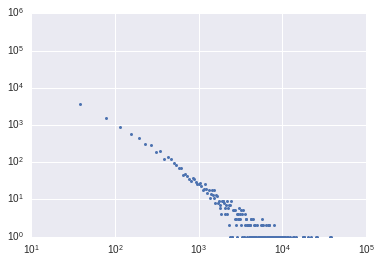

In [22]:
def draw_log_hist(x):
    """Draw tokens histogram in log scales"""
    feat_cnt = x.sum(axis=0).tolist()[0]
    hist = np.histogram(feat_cnt, bins = 1000)
    plt.loglog(hist[1][:-1],hist[0],'o', ms = 3)

    plt.show()
    
    return np.array(feat_cnt)

features_counts = draw_log_hist(X)

Проведем отбор признаков. В самом простом случае просто удаляем признаки, имеющие ненулевое значение у менее, чем 100 пользователей.

In [11]:
X1 = X.tocsc()[:, [x for x in xrange(len(features_counts)) if features_counts[x] > 100]].toarray()

In [12]:
X1.shape

(7199, 5006)

 Пришлось сделать такой костыль для list comprehension в ячейке сверху, потому что оригинал выдавал массив [7199 x 1]

Вариант задания генерируется на основании вашего ника в техносфере.

In [13]:
USER_NAME = "d.shevyakov"
OPTIMIZATION_ALGORITHMS = ["stochastic gradient descent", "Newton method"]
REGULARIZATIONS = ["L1", "L2"]

print "My homework 5 algorithm is: Logistic regression with %s regularization optimized by %s" % (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    OPTIMIZATION_ALGORITHMS[hash(USER_NAME[::-1]) % 2]
)

My homework 5 algorithm is: Logistic regression with L2 regularization optimized by Newton method


Реализуем выбранный алгоритм

In [24]:
class LogisticRegression():
    '''
    Logistic regression with parameters:
    'alpha'   : learning_rate (default = 1.)
    'C'  : regularization coeff (~ 1 / lambda) (default = 1.)
    'epsilon' : stop-tolerance (default = 1e-3)
    'max_iter': limit of iterations (default = 100)
    'initialize' : option for choosing initial theta values, 'zeros', 'random' or 'features' (default = 'zeros')
    'verbose' : level of outputs (default 1)
    'scale' : scaling X (default True)
    '''
    def __init__(self, alpha = 1., epsilon = 1e-3, verbose = 1, \
                 C = 1., max_iter = 100, init = 'zeros', scale = True):        
        self.alpha = alpha
        self.lambd = 1.
        self.epsilon = epsilon
        self.verbose = verbose
        self.C = C
        self.max_iter = max_iter
        self.init = init
        self.scale = scale
        
        if self.verbose >= 1: 
            print '#####################\nLogistic Regression: initialized with parameters:'
            print '%s\t:\t%f\n%s\t:\t%f\n%s\t:\t%f\n%s\t:\t%s\n%s:\t%f\n%s\t:\t%f\n%s\t:%s' \
            % ('alpha', self.alpha, 'C', self.C, 'epsilon', self.epsilon, \
               'initial', self.init, 'max_iter', self.max_iter, 'verbose', self.verbose, 'scale', self.scale)
    
    def _add_bias(self, X):
        bias = np.ones(shape=(self.L, 1))
        added = np.concatenate((bias, X), axis = 1)
        reshaped = np.reshape(added, (self.L, self.N + 1))
        if self.verbose == 2: 
            print '# _add_bias #'
            print 'X: ', X.shape
            print 'bias: ', bias.shape
        return reshaped
        
    def _sigmoid(self, z):
        return 1./ (1. + np.exp(-z))
    
    def _h(self, theta, X):
        h = self._sigmoid(np.dot(X, theta))
        h = np.abs(h - 1e-6)
        if self.verbose == 2: 
            print 'h:', h.shape
            print '# h #'            
        return h
    
    def _gradient(self, theta, X, y):
        if self.verbose == 2:
            print '# gradient #'
            print 'theta:', theta.shape
            print 'X:', X.shape
            print 'y:', y.shape
        gradient = np.ndarray(shape = theta.shape)        
        gradient[0, :] = (self.C / self.L) * np.dot(np.transpose(X), self._sigmoid(np.dot(X, theta)) - y)[0, :] 
        gradient[1:, :] = (self.C / self.L) * np.dot(np.transpose(X), self._sigmoid(np.dot(X, theta)) - y)[1:, :] + self.lambd * theta[1:, :] 
        return gradient
    
    def _hessian(self, theta, X):
        
        X_T = np.transpose(X)
        H = self._h(theta, X)
        S = np.diag((np.multiply(H, 1 - H)).ravel())
        SX = np.dot(S, X)
        X_TSX = np.dot(X_T, SX)
        reg = np.eye(self.N + 1)
        reg[0, 0] = 0  
        hessian = (self.C / self.L) * X_TSX + reg 
        
        if self.verbose == 2: 
            print '# hessian #'
            print 'X_T:', X_T.shape
            print 'h:', H.shape
            print 'S:', S.shape
            print 'Hessian:', hessian.shape
        
        return hessian
    
    def _new_step(self, hessian, gradient):
        try:
            d = np.linalg.solve(hessian, - gradient)
        except np.linalg.LinAlgError:
            d = np.linalg.lstsq(hessian, - gradient)
        finally:
            d = - np.dot(np.linalg.pinv(hessian), gradient)

        return d
    
    def _J(self, theta, X, y):
        if self.verbose == 2: print '# J #'
        J = (self.C / self.L) * \
            (- np.dot(np.transpose(y) , np.log(self._h(theta, X))) \
             - np.dot(np.transpose(1 - y),  np.log(1 - self._h(theta, X)))) \
             + self.lambd * np.sum(np.square(theta))
        if self.verbose == 2: print 'J:', J.shape
        return J
    
    def _initial_theta(self, X, y):
        theta = 0
        if self.init == 'features':
            theta = np.ndarray(shape = (self.N + 1,1))
            theta_ = [1] * (self.N + 1)
            for j in range(self.N + 1):
                theta_[j] = np.inner(y[:, 0], X[:, j]) / np.inner(X[:, j], X[:, j])
            theta[:, 0] = theta_
            
        elif self.init == 'random':
            theta = np.random.uniform(low = -1./(2*(self.N + 1)), high = 1./(2*(self.N + 1)),size = (self.N + 1, 1))
        
        elif self.init == 'zeros':
            theta = np.zeros(shape = (self.N + 1,1))

        if self.verbose == 2: print 'initial theta:', theta
        return theta
    
    def _newton(self, X, y):
        theta = self._initial_theta(X, y)
        k = 0
        J = self._J(theta, X, y)
        self.Js = [J[0]]
        if self.verbose >= 1: print 'Iteration :%d\t J:%f' %(k, J)
        while (k < self.max_iter):
            k += 1
            gradient = self._gradient(theta, X, y)
            hessian = self._hessian(theta, X)
            d = self._new_step(hessian, gradient)
            theta_new = theta + self.alpha * d
            J_new = self._J(theta_new, X, y)
            if np.max(abs(theta_new - theta)) < self.epsilon or (J_new >= J):
                break
            theta = theta_new
            J = J_new
            self.Js.append(J[0])
            if self.verbose >= 1: print 'Iteration :%d\t J:%f' %(k, J)
        return theta
    
    def fit(self, X, y=None):
        self.L, self.N = X.shape
        if self.scale:
            from sklearn.preprocessing import StandardScaler
            scaler = StandardScaler()
            self._X = scaler.fit_transform(X)
        self._X = self._add_bias(self._X)
        self.theta_ = self._newton(self._X, y)
        if self.verbose >= 1: print 'Logistic Regression: fit finished!\n#####################'

        return self
        
    def predict_proba(self, X):        
        self.L, self.N = X.shape
        if self.scale:
            from sklearn.preprocessing import StandardScaler
            scaler = StandardScaler()
            self._X = scaler.fit_transform(X)
        self._X = self._add_bias(self._X)
        return self._h(self.theta_ ,self._X)#.T.tolist()[0]
    
    def predict(self, X = None, threshold = .5):
        if X == None:
            X = self._X
        else:
            if self.scale:
                from sklearn.preprocessing import StandardScaler
                scaler = StandardScaler()
                self._X = scaler.fit_transform(X)
            self.L, self.N = X.shape
            X = self._add_bias(self._X)

        return (self._h(self.theta_, X) > threshold)#.T.tolist()[0]
    

In [16]:
#class LogisticRegression():
#    
#    def fit(self, X, Y=None):
#        return self
#    
#    def predict_proba(self, X):
#        import numpy.random as nr
#        return nr.random((X.shape[0], 2))

Реализуем метрику качества, используемую в соревновании: площадь под ROC кривой

In [17]:
def auroc(y_prob, y_true):
    from itertools import product

    y_true_pos_inds = [i for i, y in enumerate(y_true) if y == 1]
    y_true_neg_inds = [i for i, y in enumerate(y_true) if y != 1]
    
    y_pos = [y_prob[i] for i in y_true_pos_inds]
    y_neg = [y_prob[i] for i in y_true_neg_inds]
    
    _product = list(product(y_pos, y_neg))
    _differencies = map(lambda (x, y): x - y, _product)
    area = np.mean(np.greater(_differencies, 0) + .5 * (np.equal(_differencies, 0)))
    
    return area

Разделим выборку с помощью методики кросс-валидации для того, чтобы настроить параметр регуляризации $C$

In [18]:
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [19]:
X1_train, X1_holdout, y_train, y_holdout = train_test_split(X1, Y, test_size = .4)

In [25]:
params = {'C' : [0.1, 1, 10, 100, 1000],
          'init' : ['zeros', 'random', 'features'],
          'scale': ['True', 'False']}
best_score = 0.
C_opt = None
init_opt = None
scale_opt = None
for c in params['C']:
    for init in params['init']:
        for scale in params['scale']:
            X1_train_tune, X1_test, Y_train_tune, Y_test = train_test_split(X1_train, y_train, test_size = .3)
            LR = LogisticRegression(C=c, init=init, scale=scale)
            %time LR.fit(X1_train_tune, Y_train_tune)
            score = auroc(Y_test, LR.predict_proba(X1_test))
            print 'C:%f\tinit:%s\tscale:%s\tscore:%f' % (c, init, scale, score)
            if best_score < score:
                best_score = score
                C_opt = c
                init_opt = init
                scale_opt = scale

#####################
Logistic Regression: initialized with parameters:
alpha	:	1.000000
C	:	0.100000
epsilon	:	0.001000
initial	:	zeros
max_iter:	100.000000
verbose	:	1.000000
scale	:True
Iteration :0	 J:0.069315


ValueError: could not broadcast input array from shape (3023) into shape (1)

In [ ]:
C = [0.0, 0.01, 0.1, 1, 10, 100, 1000, 10000]

def select_reg_parameter(C, X, Y):
    return C.index(max(C))

index = select_reg_parameter(C, X1, Y)
print index


Выбираем наилучшее значение $C$, и классифицируем неизвестных пользователей и строим ROC-кривую

In [ ]:
def classify(X, Y, test_size, C):
    tpr = [1] * 2400
    fpr = [0.01] * 2400
    roc_auc = 0.51
    
    return tpr, fpr, roc_auc

tpr, fpr, roc_auc = classify(X1, Y, 0.3, C[index])

print "Area under the ROC curve : %f" % roc_auc

def plot_roc_curve(tpr, fpr, roc_auc):
    """Plot ROC curve"""
    
    # Your code here
    
    return

plot_roc_curve(tpr, fpr, roc_auc)

С помощью полученной модели предсказываем категории для неизвестных пользователей из соревнования и загружаем на kaggle в нужном формате. ДЗ принимается только при наличии загруженных данных на kaggle.